In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import numpy as np
import pandas as pd
import scipy.signal as spsig
import scipy.stats as spstats
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from pasna2021 import PasnaFly
from pasna2021 import utils as pu

import warnings
warnings.filterwarnings('ignore')

# Get file names of ROI CSVs to import

In [2]:
data_dir_exp = '../data/iav_tnt/exp'
data_dir_ctl = '../data/iav_tnt/ctl'
roi_csv_fns_exp = sorted([x for x in os.listdir(data_dir_exp) if x[-3:]=="csv" and x[0]!="."])
roi_csv_fns_ctl = sorted([x for x in os.listdir(data_dir_ctl) if x[-3:]=="csv" and x[0]!="."])

# Exclude flies

In [3]:
exclusion_flies_exp = ['210513_05'
                      ]
exclusion_flies_ctl = [
                      ]
roi_csv_fns_exp = [x for x in roi_csv_fns_exp if not any(exc in x for exc in exclusion_flies_exp)]
roi_csv_fns_ctl = [x for x in roi_csv_fns_ctl if not any(exc in x for exc in exclusion_flies_ctl)]

# Create PasnaFly objects and detect peaks

In [4]:
flies_exp = [PasnaFly(os.path.join(data_dir_exp, csv_fn), trim_data=True) for csv_fn in roi_csv_fns_exp]
flies_ctl = [PasnaFly(os.path.join(data_dir_ctl, csv_fn), trim_data=True) for csv_fn in roi_csv_fns_ctl]
_ = [fly.detect_peaks() for fly in flies_exp]
_ = [fly.detect_peaks() for fly in flies_ctl]

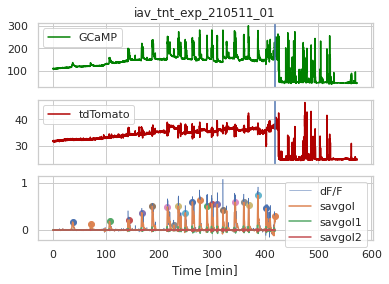

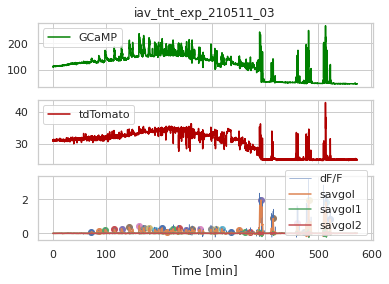

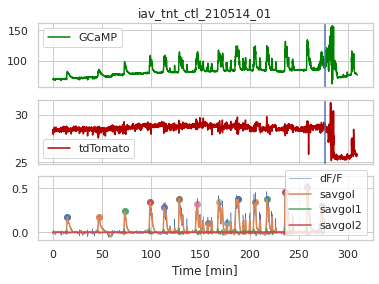

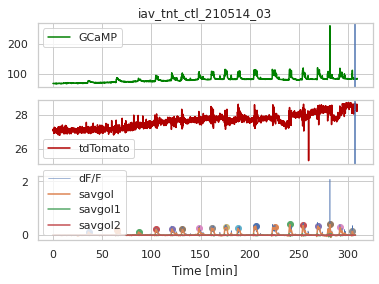

In [5]:
# Only plotting a few as demo; remove '[0:2]' to plot all flies
figs = [fly.plot(raw=True, figsize=None) for fly in flies_exp[0:2]]
figs = [fly.plot(raw=True, figsize=None) for fly in flies_ctl[0:2]]

# Interval duration (Figure S2 C,D,K)

In [6]:
n_peaks_analyzed = 12

peak_ints_exp = pu.uneven_list2d_to_np([fly.peak_intervals for fly in flies_exp])
fly_names_exp = [fly.name for fly in flies_exp]
fly_multiidx_exp = pd.MultiIndex.from_arrays([['exp']*len(fly_names_exp), fly_names_exp], names=['group','fly'])
peak_ints_exp_df = pd.DataFrame(peak_ints_exp, index=fly_multiidx_exp).rename_axis(columns='interval')

peak_ints_ctl = pu.uneven_list2d_to_np([fly.peak_intervals for fly in flies_ctl])
fly_names_ctl = [fly.name for fly in flies_ctl]
fly_multiidx_ctl = pd.MultiIndex.from_arrays([['ctl']*len(fly_names_ctl), fly_names_ctl], names=['group','fly'])
peak_ints_ctl_df = pd.DataFrame(peak_ints_ctl, index=fly_multiidx_ctl).rename_axis(columns='interval')

peak_ints_df = pd.concat([peak_ints_exp_df, peak_ints_ctl_df])
peak_ints_df_trimmed = peak_ints_df.iloc[:,:n_peaks_analyzed-1]

peak_ints_df_long = peak_ints_df.reset_index().melt(id_vars=['fly', 'group'], value_name='duration')
peak_ints_df_trimmed_long = peak_ints_df_trimmed.reset_index().melt(id_vars=['fly', 'group'], value_name='duration')

Text(0.5, 0, 'Interval #')

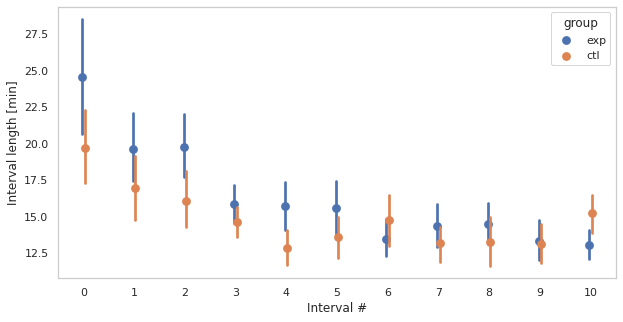

In [7]:
plt.figure(figsize=(10,5))
sns.pointplot(data=peak_ints_df_trimmed_long, x='interval', y='duration', hue='group', ci=95, join=False, dodge=True)
plt.grid(False)
plt.ylabel('Interval length [min]')
plt.xlabel('Interval #')

### T-test for each peak

In [8]:
cat1 = peak_ints_df_trimmed.reset_index()[peak_ints_df_trimmed.reset_index()['group']=='exp']
cat2 = peak_ints_df_trimmed.reset_index()[peak_ints_df_trimmed.reset_index()['group']=='ctl']

pvals=[]
for i in range(n_peaks_analyzed-1):
    ttest_result = spstats.ttest_ind(cat1[i], cat2[i], nan_policy='omit')
    pvals.append(ttest_result[1])
    print(f'Interval {i:>2}: ' + str(ttest_result))
multipletests(pvals, alpha=0.05, method='holm')

Interval  0: Ttest_indResult(statistic=1.7192105296636984, pvalue=0.09176202776099593)
Interval  1: Ttest_indResult(statistic=1.4468343643863228, pvalue=0.15418388268109642)
Interval  2: Ttest_indResult(statistic=2.3172642375682613, pvalue=0.024623470044469478)
Interval  3: Ttest_indResult(statistic=1.294639203914408, pvalue=0.20139174584853822)
Interval  4: Ttest_indResult(statistic=2.489103141594496, pvalue=0.016179517617987936)
Interval  5: Ttest_indResult(statistic=1.5564237755078028, pvalue=0.12604329111158175)
Interval  6: Ttest_indResult(statistic=-1.1416450784053878, pvalue=0.2591501032139847)
Interval  7: Ttest_indResult(statistic=1.0918347585171393, pvalue=0.28024522118942535)
Interval  8: Ttest_indResult(statistic=1.0489106159974457, pvalue=0.29958319049277293)
Interval  9: Ttest_indResult(statistic=0.1782905853691864, pvalue=0.859261048647795)
Interval 10: Ttest_indResult(statistic=-2.4894184920144498, pvalue=0.016391525070752155)


(array([False, False, False, False, False, False, False, False, False,
        False, False]),
 array([0.73409622, 0.9251033 , 0.22161123, 1.        , 0.17797469,
        0.88230304, 1.        , 1.        , 1.        , 1.        ,
        0.17797469]),
 0.004652171732197341,
 0.004545454545454546)

# Developmental Time (i.e. Embryo:VNC ratio) vs Peak AUC (Figure 3 H,L; Figure S2 G)

In [9]:
## Compute peak AUCs (area under the curve)
n_peaks_analyzed = 12
left_pad = 3 #21 seconds before peak
right_pad = 4 #28 seconds after peak

_ = [(fly.compute_peak_bounds(), fly.compute_peak_aucs_from_peaks(left_pad=left_pad, right_pad=right_pad)) for fly in flies_exp]
_ = [(fly.compute_peak_bounds(), fly.compute_peak_aucs_from_peaks(left_pad=left_pad, right_pad=right_pad)) for fly in flies_ctl]

## Get Embryo:VNC ratio from summary excel spreadsheets

# Control
summary_xl_fn_ctl = [os.path.join(data_dir_ctl, x) for x in os.listdir(data_dir_ctl) if x[-4:]=="xlsx" and x[0]!="." and 'summary' in x][0]

summary_xl = pd.read_excel(summary_xl_fn_ctl, header = [0,1], index_col=0, na_values=['no'])
summary_xl = summary_xl[[(pd.notnull(x) and x[0:4].isnumeric()) for x in summary_xl.index.to_list()]]
names = summary_xl.index.to_list()
new_names = []
for i in range(len(names)):
    name = names[i]
    if name[-2] == "_":
        new_name = name[:-1] + "0" + name[-1:]
        new_names.append(new_name)
    else:
        new_names.append(name)
summary_xl = summary_xl.rename(index=dict(zip(names,new_names)))
embryo_to_vnc_at_peaks_ctl = summary_xl.iloc[:,[8]+list(range(26,37))]
embryo_to_vnc_at_peaks_ctl.columns = pd.Index(list(range(1,13)), name='peak')

for fly in flies_ctl:
    fly_key_cand = [x for x in embryo_to_vnc_at_peaks_ctl.index.values if fly.name[-9:] in x]
    if len(fly_key_cand) == 0:
        print("Fly key error: " + fly.name[-9:])
    else:
        ratios = embryo_to_vnc_at_peaks_ctl.loc[fly_key_cand[0]]
        fly.peaks_embryo_to_vnc = ratios.to_list()

# Experimental
summary_xl_fn_exp = [os.path.join(data_dir_exp, x) for x in os.listdir(data_dir_exp) if x[-4:]=="xlsx" and x[0]!="." and 'summary' in x][0]

summary_xl = pd.read_excel(summary_xl_fn_exp, header = [0,1], index_col=0, na_values=['no'])
summary_xl = summary_xl[[(pd.notnull(x) and x[0:4].isnumeric()) for x in summary_xl.index.to_list()]]
names = summary_xl.index.to_list()
new_names = []
for i in range(len(names)):
    name = names[i]
    if name[-2] == "_":
        new_name = name[:-1] + "0" + name[-1:]
        new_names.append(new_name)
    else:
        new_names.append(name)
summary_xl = summary_xl.rename(index=dict(zip(names,new_names)))
embryo_to_vnc_at_peaks_exp = summary_xl.iloc[:,[8]+list(range(26,37))]
embryo_to_vnc_at_peaks_exp.columns = pd.Index(list(range(1,13)), name='peak')

for fly in flies_exp:
    fly_key_cand = [x for x in embryo_to_vnc_at_peaks_exp.index.values if fly.name[-9:] in x]
    if len(fly_key_cand) == 0:
        print("Fly key error: " + fly.name[-9:])
    else:
        ratios = embryo_to_vnc_at_peaks_exp.loc[fly_key_cand[0]]
        fly.peaks_embryo_to_vnc = ratios.to_list()

        
## Create dataframes with peak amplitudes, AUCs, and Embryo:VNC ratios
peak_amps_ratios_exp = pd.DataFrame(pu.flatten_nested_list([list(zip(fly.peak_amplitudes, fly.peak_aucs, fly.peaks_embryo_to_vnc)) for fly in flies_exp]), columns=['amps', 'aucs', 'ratios'])
peak_amps_ratios_ctl = pd.DataFrame(pu.flatten_nested_list([list(zip(fly.peak_amplitudes, fly.peak_aucs, fly.peaks_embryo_to_vnc)) for fly in flies_ctl]), columns=['amps', 'aucs', 'ratios'])
peak_amps_ratios_exp['group'] = 'exp'
peak_amps_ratios_ctl['group'] = 'ctl'
peak_amps_ratios = pd.concat([peak_amps_ratios_exp, peak_amps_ratios_ctl]).reset_index()

In [10]:
## Bin developmental time into four windows
bins = np.arange(2.0, 2.9, 0.2)
bin_assignments = pd.cut(peak_amps_ratios['ratios'], bins, labels=False)
bin_assignments[np.isnan(bin_assignments)] = -1
bin_assignments = bin_assignments.astype(int)
peak_amps_ratios['bin'] = bin_assignments
peak_amps_ratios_binned = peak_amps_ratios[peak_amps_ratios['bin']>=0]
peak_amps_ratios_binned_padded = peak_amps_ratios_binned.copy()
for i in range(len(bins)-1):
    peak_amps_ratios_binned_padded = peak_amps_ratios_binned_padded.append({'amps':np.nan, 'aucs':np.nan, 'bin':i, 'group':'exp'}, ignore_index=True)

Text(0, 0.5, 'AUC [%*min]')

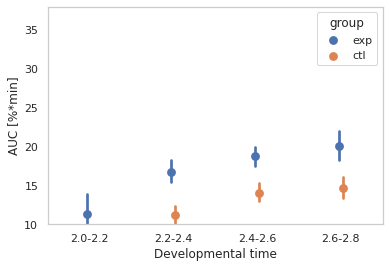

In [11]:
plt.figure()
ax = sns.pointplot(data=peak_amps_ratios_binned_padded, x='bin', y='aucs', hue='group', ci=95, join=False, dodge=True)
_=ax.set_xticklabels([f'{x:.2}-{y:.2}' for x,y in zip(bins[:-1], bins[1:])])
plt.grid(False)
plt.ylim([10,38])
plt.xlabel('Developmental time')
plt.ylabel('AUC [%*min]')

### T-test for each bin

In [12]:
cat1 = peak_amps_ratios_binned[peak_amps_ratios_binned['group']=='exp']
cat2 = peak_amps_ratios_binned[peak_amps_ratios_binned['group']=='ctl']

pvals=[]
for i in range(len(bins)-1):
    ttest_result = spstats.ttest_ind(cat1[cat1['bin']==i]['aucs'], cat2[cat2['bin']==i]['aucs'], nan_policy='omit')
    pvals.append(ttest_result[1])
    print(f'Bin {i:>2}: ' + str(ttest_result))
multipletests(pvals, alpha=0.05, method='holm')

Bin  0: Ttest_indResult(statistic=0.6727032010457556, pvalue=0.5113670368538298)
Bin  1: Ttest_indResult(statistic=3.945920965941062, pvalue=0.0001366231319666415)
Bin  2: Ttest_indResult(statistic=4.9652871467145365, pvalue=1.2926198464722924e-06)
Bin  3: Ttest_indResult(statistic=4.2302464493475425, pvalue=4.195456895207281e-05)


(array([False,  True,  True,  True]),
 array([5.11367037e-01, 2.73246264e-04, 5.17047939e-06, 1.25863707e-04]),
 0.012741455098566168,
 0.0125)

# CDF of developmental times of peaks (Figure 3 G,K; Figure S2 F)

(1.9, 3.0)

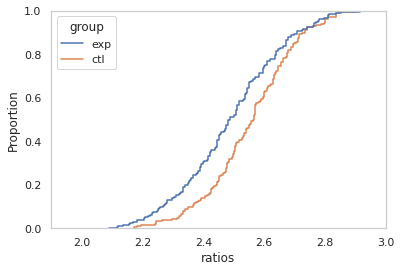

In [13]:
plt.figure()
sns.ecdfplot(data=peak_amps_ratios, x='ratios', hue='group')
plt.grid(False)
plt.xlim([1.9, 3.0])

# Post-myogenic phase Calcium Baseline (Figure 3 I,M; Figure S2 H)

In [14]:
window = (85,70) # 10m-8.25m before first peak
window_mean_exp = np.asarray([fly.get_pre_pasna_baseline([window]) for fly in flies_exp])
window_mean_ctl = np.asarray([fly.get_pre_pasna_baseline([window]) for fly in flies_ctl])

fly_names_exp = [fly.name for fly in flies_exp]
names_multi_idx_exp = pd.MultiIndex.from_arrays([['exp']*len(fly_names_exp), fly_names_exp], names=['group','fly name'])
fly_names_ctl = [fly.name for fly in flies_ctl]
names_multi_idx_ctl = pd.MultiIndex.from_arrays([['ctl']*len(fly_names_ctl), fly_names_ctl], names=['group','fly name'])

window_mean_exp_df = pd.DataFrame(window_mean_exp, columns=['Normalized GCaMP6s'], index=names_multi_idx_exp)
window_mean_ctl_df = pd.DataFrame(window_mean_ctl, columns=['Normalized GCaMP6s'], index=names_multi_idx_ctl)
window_mean_df = pd.concat([window_mean_exp_df, window_mean_ctl_df])

<AxesSubplot:xlabel='group', ylabel='Normalized GCaMP6s'>

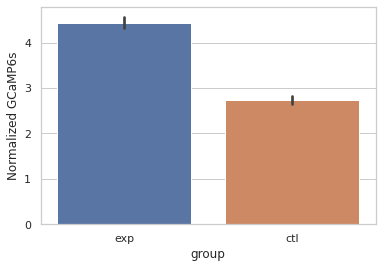

In [15]:
sns.barplot(data=window_mean_df.reset_index(level=0, inplace=False), y='Normalized GCaMP6s', x='group')